# COVID-19 Literature Clustering



### Goal
Given a large amount of literature and rapidly spreading COVID-19, it is difficult for a scientist to keep up with the research community promptly. Can we cluster similar research articles together to make it easier for health professionals to find relevant research articles? Clustering can be used to create a tool to identify similar articles, given a target article. It can also reduce the number of articles one has to go through as one can focus on a cluster of articles rather than all. 

**Approach**:
<ol>
    <li>Unsupervised Learning task, because we don't have labels for the articles</li>
    <li>Clustering and Dimensionality Reduction task </li>
    <li>See how well labels from K-Means classify</li>
    <li>Use N-Grams with Hash Vectorizer</li>
    <li>Use plain text with Tf-idf</li>
    <li>Use K-Means for clustering</li>
    <li>Use t-SNE for dimensionality reduction</li>
    <li>Use PCA for dimensionality reduction</li>
    <li>There is no continuous flow of data, no need to adjust to changing data, and the data is small enough to fit in memmory: Batch Learning</li>
    <li>Altough, there is no continuous flow of data, our approach has to be scalable as there will be more literature later</li>
</ol>

### Dataset Description

>*In response to the COVID-19 pandemic, the White House and a coalition of leading research groups have prepared the COVID-19 Open Research Dataset (CORD-19). CORD-19 is a resource of over 29,000 scholarly articles, including over 13,000 with full text, about COVID-19, SARS-CoV-2, and related coronaviruses. This freely available dataset is provided to the global research community to apply recent advances in natural language processing and other AI techniques to generate new insights in support of the ongoing fight against this infectious disease. There is a growing urgency for these approaches because of the rapid acceleration in new coronavirus literature, making it difficult for the medical research community to keep up.*
#### Cite: [COVID-19 Open Research Dataset Challenge (CORD-19) | Kaggle](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge) <br>


# Load the Data
Load the data following the notebook by Ivan Ega Pratama, from Kaggle.
#### Cite: [Dataset Parsing Code | Kaggle, COVID EDA: Initial Exploration Tool](https://www.kaggle.com/ivanegapratama/covid-eda-initial-exploration-tool)

### Loading Metadata

In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import json

import matplotlib.pyplot as plt
plt.style.use('ggplot')

Let's load the metadata of the dateset. 'title' and 'journal' attributes may be useful later when we cluster the articles to see what kinds of articles cluster together.

In [11]:
root_path = 'CORD-19-research-challenge/'
metadata_path = f'{root_path}/metadata.csv'
meta_df = pd.read_csv(metadata_path, dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'doi': str
})
meta_df.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url
0,xqhn0vbp,1e1286db212100993d03cc22374b624f7caee956,PMC,Airborne rhinovirus detection and effect of ul...,10.1186/1471-2458-3-5,PMC140314,12525263,no-cc,"BACKGROUND: Rhinovirus, the most common cause ...",2003-01-13,"Myatt, Theodore A; Johnston, Sebastian L; Rudn...",BMC Public Health,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
1,gi6uaa83,8ae137c8da1607b3a8e4c946c07ca8bda67f88ac,PMC,Discovering human history from stomach bacteria,10.1186/gb-2003-4-5-213,PMC156578,12734001,no-cc,Recent analyses of human pathogens have reveal...,2003-04-28,"Disotell, Todd R",Genome Biol,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
2,le0ogx1s,NaN,PMC,A new recruit for the army of the men of death,10.1186/gb-2003-4-7-113,PMC193621,12844350,no-cc,"The army of the men of death, in John Bunyan's...",2003-06-27,"Petsko, Gregory A",Genome Biol,NaN,NaN,False,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
3,fy4w7xz8,0104f6ceccf92ae8567a0102f89cbb976969a774,PMC,Association of HLA class I with severe acute r...,10.1186/1471-2350-4-9,PMC212558,12969506,no-cc,BACKGROUND: The human leukocyte antigen (HLA) ...,2003-09-12,"Lin, Marie; Tseng, Hsiang-Kuang; Trejaut, Jean...",BMC Med Genet,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...
4,0qaoam29,5b68a553a7cbbea13472721cd1ad617d42b40c26,PMC,A double epidemic model for the SARS propagation,10.1186/1471-2334-3-19,PMC222908,12964944,no-cc,BACKGROUND: An epidemic of a Severe Acute Resp...,2003-09-10,"Ng, Tuen Wai; Turinici, Gabriel; Danchin, Antoine",BMC Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...


In [3]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51078 entries, 0 to 51077
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   cord_uid                     51078 non-null  object
 1   sha                          38022 non-null  object
 2   source_x                     51078 non-null  object
 3   title                        50920 non-null  object
 4   doi                          47741 non-null  object
 5   pmcid                        41082 non-null  object
 6   pubmed_id                    37861 non-null  object
 7   license                      51078 non-null  object
 8   abstract                     42352 non-null  object
 9   publish_time                 51070 non-null  object
 10  authors                      48891 non-null  object
 11  journal                      46368 non-null  object
 12  Microsoft Academic Paper ID  964 non-null    object
 13  WHO #Covidence               17

### Fetch All of JSON File Path

Get path to all JSON files:

In [12]:
all_json = glob.glob(f'{root_path}/**/*.json', recursive=True)
len(all_json)

59311

### Helper Functions

 File Reader Class

In [13]:
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'
    
# Helper function adds break after every words when character length reach to certain amount. This is for the interactive plot so that hover tool fits the screen.
    
def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data


### Load the Data into DataFrame

Using the helper functions, let's read in the articles into a DataFrame that can be used easily:

In [14]:
dict_ = {'paper_id': [], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}
for idx, entry in enumerate(all_json):
    try:
        if idx % (len(all_json) // 10) == 0:
            print(f'Processing index: {idx} of {len(all_json)}')
        content = FileReader(entry)

        # get metadata information
        meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
        # no metadata, skip this paper
        if len(meta_data) == 0:
            continue

        dict_['paper_id'].append(content.paper_id)
        dict_['abstract'].append(content.abstract)
        dict_['body_text'].append(content.body_text)

        # also create a column for the summary of abstract to be used in a plot
        if len(content.abstract) == 0: 
            # no abstract provided
            dict_['abstract_summary'].append("Not provided.")
        elif len(content.abstract.split(' ')) > 100:
            # abstract provided is too long for plot, take first 300 words append with ...
            info = content.abstract.split(' ')[:100]
            summary = get_breaks(' '.join(info), 40)
            dict_['abstract_summary'].append(summary + "...")
        else:
            # abstract is short enough
            summary = get_breaks(content.abstract, 40)
            dict_['abstract_summary'].append(summary)

        # get metadata information
        meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]

        try:
            # if more than one author
            authors = meta_data['authors'].values[0].split(';')
            if len(authors) > 2:
                # more than 2 authors, may be problem when plotting, so take first 2 append with ...
                dict_['authors'].append(". ".join(authors[:2]) + "...")
            else:
                # authors will fit in plot
                dict_['authors'].append(". ".join(authors))
        except Exception as e:
            # if only one author - or Null valie
            dict_['authors'].append(meta_data['authors'].values[0])

        # add the title information, add breaks when needed
        try:
            title = get_breaks(meta_data['title'].values[0], 40)
            dict_['title'].append(title)
        # if title was not provided
        except Exception as e:
            dict_['title'].append(meta_data['title'].values[0])

        # add the journal information
        dict_['journal'].append(meta_data['journal'].values[0])
        
    
    except Exception as e:
        continue
    
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])
df_covid.head()

Processing index: 0 of 59311
Processing index: 5931 of 59311
Processing index: 11862 of 59311
Processing index: 17793 of 59311
Processing index: 23724 of 59311
Processing index: 29655 of 59311
Processing index: 35586 of 59311
Processing index: 41517 of 59311
Processing index: 47448 of 59311
Processing index: 53379 of 59311
Processing index: 59310 of 59311


,paper_id,abstract,body_text,authors,title,journal,abstract_summary
0,0015023cc06b5362d332b3baf348d11567ca2fbb,word count: 194 22 Text word count: 5168 23 24...,"VP3, and VP0 (which is further processed to VP...",Joseph C. Ward. Lidia Lasecka-Dykes...,The RNA pseudoknots in foot-and-mouth disease...,NaN,word count: 194 22 Text word count: 5168 23 2...
1,00340eea543336d54adda18236424de6a5e91c9d,"During the past three months, a new coronaviru...","In December 2019, a novel coronavirus, SARS-Co...",Carla Mavian. Simone Marini...,Regaining perspective on SARS-CoV-2<br>molecu...,NaN,"During the past three months, a new coronavir..."
2,004f0f8bb66cf446678dc13cf2701feec4f36d76,,The 2019-nCoV epidemic has spread across China...,Hanchu Zhou. Jianan Yang...,Healthcare-resource-adjusted<br>vulnerabiliti...,NaN,Not provided.
3,00911cf4f99a3d5ae5e5b787675646a743574496,The fast accumulation of viral metagenomic dat...,"Metagenomic sequencing, which allows us to dir...",Jiayu Shang. Yanni Sun,CHEER: hierarCHical taxonomic<br>classificati...,NaN,The fast accumulation of viral metagenomic<br...
4,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,Infectious bronchitis (IB) causes significant ...,"Infectious bronchitis (IB), which is caused by...",Salman L. Butt. Eric C. Erwood...,"Real-time, MinION-based, amplicon<br>sequenci...",NaN,Infectious bronchitis (IB) causes<br>signific...


In [15]:
dict_ = None

# Adding the Word Count Columns

Adding word count columns for both abstract and body_text can be useful parameters later:

In [16]:
df_covid['abstract_word_count'] = df_covid['abstract'].apply(lambda x: len(x.strip().split()))
df_covid['body_word_count'] = df_covid['body_text'].apply(lambda x: len(x.strip().split()))
df_covid.head()

,paper_id,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count
0,0015023cc06b5362d332b3baf348d11567ca2fbb,word count: 194 22 Text word count: 5168 23 24...,"VP3, and VP0 (which is further processed to VP...",Joseph C. Ward. Lidia Lasecka-Dykes...,The RNA pseudoknots in foot-and-mouth disease...,NaN,word count: 194 22 Text word count: 5168 23 2...,241,1728
1,00340eea543336d54adda18236424de6a5e91c9d,"During the past three months, a new coronaviru...","In December 2019, a novel coronavirus, SARS-Co...",Carla Mavian. Simone Marini...,Regaining perspective on SARS-CoV-2<br>molecu...,NaN,"During the past three months, a new coronavir...",175,2549
2,004f0f8bb66cf446678dc13cf2701feec4f36d76,,The 2019-nCoV epidemic has spread across China...,Hanchu Zhou. Jianan Yang...,Healthcare-resource-adjusted<br>vulnerabiliti...,NaN,Not provided.,0,755
3,00911cf4f99a3d5ae5e5b787675646a743574496,The fast accumulation of viral metagenomic dat...,"Metagenomic sequencing, which allows us to dir...",Jiayu Shang. Yanni Sun,CHEER: hierarCHical taxonomic<br>classificati...,NaN,The fast accumulation of viral metagenomic<br...,139,5188
4,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,Infectious bronchitis (IB) causes significant ...,"Infectious bronchitis (IB), which is caused by...",Salman L. Butt. Eric C. Erwood...,"Real-time, MinION-based, amplicon<br>sequenci...",NaN,Infectious bronchitis (IB) causes<br>signific...,1647,4003


In [17]:
df_covid['abstract'].describe(include='all')

count     36009
unique    26249
top            
freq       9704
Name: abstract, dtype: object

# Data Pre-processing-Handle Possible Duplicates

When we look at the unique values above, we can see that there are duplicates. It may have caused because of author submiting the article to multiple journals. Let's remove the duplicats from our dataset:

In [18]:
df_covid.dropna(inplace=True)
df_covid = df_covid[df_covid.abstract != ''] #Remove rows which are missing abstracts
df_covid = df_covid[df_covid.body_text != ''] #Remove rows which are missing body_text
df_covid.drop_duplicates(['abstract', 'body_text'], inplace=True) # remove duplicate rows having same abstract and body_text
df_covid['abstract'].describe(include='all')

count                                                 24584
unique                                                24552
top       Travel Medicine and Infectious Disease xxx (xx...
freq                                                      5
Name: abstract, dtype: object

In [19]:
df_covid['body_text'].describe(include='all')

count                                                 24584
unique                                                24584
top       The study of viral genetics largely relies on ...
freq                                                      1
Name: body_text, dtype: object

It looks like we didn't have duplicates. Instead, it was articles without Abstracts.

# Take a Look at the Data:

In [12]:
df_covid.head()

,paper_id,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count
1625,00142f93c18b07350be89e96372d240372437ed9,Dendritic cells (DCs) are specialized antigen-...,iNTRODUCTiON Human beings are constantly expos...,"Geginat, Jens. Nizzoli, Giulia...",Immunity to Pathogens Taught by Specialized<b...,Front Immunol,Dendritic cells (DCs) are specialized<br>anti...,309,5305
1626,0022796bb2112abd2e6423ba2d57751db06049fb,Dengue has a negative impact in low-and lower ...,Pathogens and vectors can now be transported r...,"Viennet, Elvina. Ritchie, Scott A....",Public Health Responses to and Challenges for...,PLoS Negl Trop Dis,Dengue has a negative impact in low-and lower...,276,7288
1627,0031e47b76374e05a18c266bd1a1140e5eacb54f,"Fecal microbial transplantation (FMT), a treat...",a1111111111 a1111111111 a1111111111 a111111111...,"McKinney, Caroline A.. Oliveira, Bruno C. M....",The fecal microbiota of healthy donor horses<...,PLoS One,"Fecal microbial transplantation (FMT), a<br>t...",141,4669
1628,00326efcca0852dc6e39dc6b7786267e1bc4f194,"Fifteen years ago, United Nations world leader...",In addition to preventative care and nutrition...,"Turner, Erin L.. Nielsen, Katie R....",A Review of Pediatric Critical Care in<br>Res...,Front Pediatr,"Fifteen years ago, United Nations world<br>le...",151,7593
1629,00352a58c8766861effed18a4b079d1683fec2ec,Posttranslational modification of proteins by ...,Ubiquitination is a widely used posttranslatio...,"Hodul, Molly. Dahlberg, Caroline L....",Function of the Deubiquitinating Enzyme USP46...,Front Synaptic Neurosci,Posttranslational modification of proteins<br...,148,3156


In [13]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24584 entries, 1625 to 36008
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             24584 non-null  object
 1   abstract             24584 non-null  object
 2   body_text            24584 non-null  object
 3   authors              24584 non-null  object
 4   title                24584 non-null  object
 5   journal              24584 non-null  object
 6   abstract_summary     24584 non-null  object
 7   abstract_word_count  24584 non-null  int64 
 8   body_word_count      24584 non-null  int64 
dtypes: int64(2), object(7)
memory usage: 1.9+ MB


In [14]:
df_covid.describe()

,abstract_word_count,body_word_count
count,24584.000000,24584.000000
mean,216.446673,4435.475106
std,137.065117,3657.421423
min,1.000000,23.000000
25%,147.000000,2711.000000
50%,200.000000,3809.500000
75%,255.000000,5431.000000
max,3694.000000,232431.000000


Now that we have our dataset loaded, we need to clean-up the text to improve any clustering or classification efforts. First, let's drop Null vales:

Limit number of articles to speed up computation:

In [20]:
# TA: Feel free to decrease this number if you think your system is getting stuck
df_covid = df_covid.head(5523)

Now let's remove punctuation from each text:

In [21]:
import re

df_covid['body_text'] = df_covid['body_text'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))
df_covid['abstract'] = df_covid['abstract'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))

Convert each text to lower case:

In [22]:
def lower_case(input_str):
    input_str = input_str.lower()
    return input_str

df_covid['body_text'] = df_covid['body_text'].apply(lambda x: lower_case(x))
df_covid['abstract'] = df_covid['abstract'].apply(lambda x: lower_case(x))

In [18]:
df_covid.head(4)

,paper_id,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count
1625,00142f93c18b07350be89e96372d240372437ed9,dendritic cells dcs are specialized antigenpre...,introduction human beings are constantly expos...,"Geginat, Jens. Nizzoli, Giulia...",Immunity to Pathogens Taught by Specialized<b...,Front Immunol,Dendritic cells (DCs) are specialized<br>anti...,309,5305
1626,0022796bb2112abd2e6423ba2d57751db06049fb,dengue has a negative impact in lowand lower m...,pathogens and vectors can now be transported r...,"Viennet, Elvina. Ritchie, Scott A....",Public Health Responses to and Challenges for...,PLoS Negl Trop Dis,Dengue has a negative impact in low-and lower...,276,7288
1627,0031e47b76374e05a18c266bd1a1140e5eacb54f,fecal microbial transplantation fmt a treatmen...,a1111111111 a1111111111 a1111111111 a111111111...,"McKinney, Caroline A.. Oliveira, Bruno C. M....",The fecal microbiota of healthy donor horses<...,PLoS One,"Fecal microbial transplantation (FMT), a<br>t...",141,4669
1628,00326efcca0852dc6e39dc6b7786267e1bc4f194,fifteen years ago united nations world leaders...,in addition to preventative care and nutrition...,"Turner, Erin L.. Nielsen, Katie R....",A Review of Pediatric Critical Care in<br>Res...,Front Pediatr,"Fifteen years ago, United Nations world<br>le...",151,7593


Now that we have the text cleaned up, we can create our features vector which can be fed into a clustering or dimensionality reduction algorithm. For our first try, we will focus on the text on the body of the articles. Let's grab that:

In [23]:
text = df_covid.drop(["paper_id", "abstract", "abstract_word_count", "body_word_count", "authors", "title", "journal", "abstract_summary"], axis=1)

In [20]:
text.head(5)

,body_text
1625,introduction human beings are constantly expos...
1626,pathogens and vectors can now be transported r...
1627,a1111111111 a1111111111 a1111111111 a111111111...
1628,in addition to preventative care and nutrition...
1629,ubiquitination is a widely used posttranslatio...


Let's transform 1D DataFrame into 1D list where each index is an article (instance), so that we can work with words from each instance:

In [24]:
text_arr = text.stack().tolist()
len(text_arr)

5523

# 2-Grams

Let's create 2D list, where each row is instance and each column is a word. Meaning, we will separate each instance into words:  

In [25]:
words = []
for ii in range(0,len(text)):
    words.append(str(text.iloc[ii]['body_text']).split(" "))

In [23]:
print(words[0][:20])

['introduction', 'human', 'beings', 'are', 'constantly', 'exposed', 'to', 'a', 'myriad', 'of', 'pathogens', 'including', 'bacteria', 'fungi', 'and', 'viruses', 'these', 'foreign', 'invaders', 'or']


What we want now is n-grams from the words where n=2 (2-gram). We will still have 2D array where each row is an instance; however, each index in that row going to be a 2-gram:

In [26]:
n_gram_all = []

for word in words:
    # get n-grams for the instance
    n_gram = []
    for i in range(len(word)-2+1):
        n_gram.append("".join(word[i:i+2]))
    n_gram_all.append(n_gram)

In [27]:
n_gram_all[0][:20]

['introductionhuman',
 'humanbeings',
 'beingsare',
 'areconstantly',
 'constantlyexposed',
 'exposedto',
 'toa',
 'amyriad',
 'myriadof',
 'ofpathogens',
 'pathogensincluding',
 'includingbacteria',
 'bacteriafungi',
 'fungiand',
 'andviruses',
 'virusesthese',
 'theseforeign',
 'foreigninvaders',
 'invadersor',
 'orcohabitants']

# Vectorize with HashingVectorizer

Now we will use HashVectorizer to create the features vector X. For now, let's limit the feature size to 2**12(4096) to speed up the computation. We might need to increase this later to reduce the collusions and improve the accuracy:

In [26]:
from sklearn.feature_extraction.text import HashingVectorizer

# hash vectorizer instance
hvec = HashingVectorizer(lowercase=False, analyzer=lambda l:l, n_features=2**12)

# features matrix X
X = hvec.fit_transform(n_gram_all)

In [27]:
X.shape

(5523, 4096)

#### Separete Training and Test Set

In [28]:
from sklearn.model_selection import train_test_split

# test set size of 20% of the data and the random seed 42 <3
X_train, X_test = train_test_split(X.toarray(), test_size=0.2, random_state=42)

print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")

X_train size: 4418
X_test size: 1105 



# Dimensionality Reduction with t-SNE
Using t-SNE we can reduce our high dimensional features vector into 2 dimensional plane. In the process, t-SNE will keep similar instances together while trying to push different instances far from each other. Resulting 2-D plane can be useful to see which articles cluster near each other:

In [29]:
# Following cell will take 15-20 minutes to run

from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=5)
X_embedded = tsne.fit_transform(X_train)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 4418 samples in 9.556s...
[t-SNE] Computed neighbors for 4418 samples in 182.858s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4418
[t-SNE] Computed conditional probabilities for sample 2000 / 4418
[t-SNE] Computed conditional probabilities for sample 3000 / 4418
[t-SNE] Computed conditional probabilities for sample 4000 / 4418
[t-SNE] Computed conditional probabilities for sample 4418 / 4418
[t-SNE] Mean sigma: 0.148522
[t-SNE] KL divergence after 250 iterations with early exaggeration: 154.855499
[t-SNE] KL divergence after 1000 iterations: 3.733860


Let's plot the result:

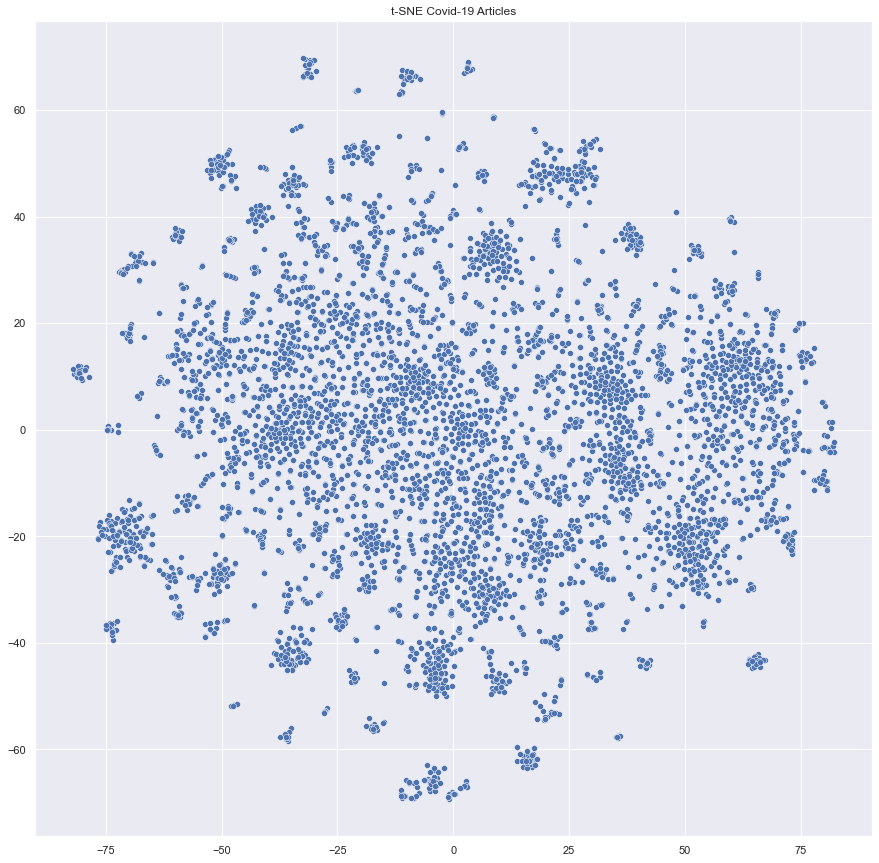

In [52]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], palette=palette)

plt.title("t-SNE Covid-19 Articles")
# plt.savefig("plots/t-sne_covid19.png")
plt.show()

We can clearly see few clusters forming. This may be a good sign that we are able to cluster similar articles together using 2-grams and HashVectorizer with 2**10 features. However, without labels it is difficult to see the clusters. For now, it looks like a blob of data... Let's try if we can use K-Means to generate our labels. We can later use this information to produce a scatterplot with labels to verify the clusters.

# Unsupervised Learning: Clustering with K-Means

Using K-means we will get the labels we need. For now, we will create 10 clusters. I am choosing this arbitrarily. We can change this later.

In [31]:
# Following cell will take 4-5 minutes to run

from sklearn.cluster import KMeans

k = 10
kmeans = KMeans(n_clusters=k, n_jobs=-1, verbose=10)
y_pred = kmeans.fit_predict(X_train)

C:\Users\samsu.DESKTOP-M7DGCTH\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Initialization complete
Iteration 0, inertia 6021.434109458904
Iteration 1, inertia 3401.4203084020546
Iteration 2, inertia 3367.158097093024
Iteration 3, inertia 3353.8272932168397
Iteration 4, inertia 3348.329039534202
Iteration 5, inertia 3345.484798905387
Iteration 6, inertia 3343.549059928588
Iteration 7, inertia 3342.152475798935
Iteration 8, inertia 3341.5033861605766
Iteration 9, inertia 3341.215155568832
Iteration 10, inertia 3341.035094403136
Iteration 11, inertia 3340.902603146712
Iteration 12, inertia 3340.7902622814486
Iteration 13, inertia 3340.7191463913346
Iteration 14, inertia 3340.671150209642
Iteration 15, inertia 3340.602912188066
Iteration 16, inertia 3340.5471045348277
Iteration 17, inertia 3340.514351003498
Iteration 18, inertia 3340.4794937097477
Iteration 19, inertia 3340.447205368594
Iteration 20, inertia 3340.4083575825084
Iteration 21, inertia 3340.377586067489
Iteration 22, inertia 3340.3489494736486
Iteration 23, inertia 3340.321915542191
Iteration 24, ine

Iteration 1, inertia 3431.740467198889
Iteration 2, inertia 3403.7928876144674
Iteration 3, inertia 3383.2656778879627
Iteration 4, inertia 3367.2589179353763
Iteration 5, inertia 3359.708462965981
Iteration 6, inertia 3355.703542104215
Iteration 7, inertia 3353.645989483354
Iteration 8, inertia 3352.6420209089356
Iteration 9, inertia 3352.236993855893
Iteration 10, inertia 3351.8534648575815
Iteration 11, inertia 3351.5821629559427
Iteration 12, inertia 3351.3578357565175
Iteration 13, inertia 3351.1419414742163
Iteration 14, inertia 3350.9267581184354
Iteration 15, inertia 3350.7953924904073
Iteration 16, inertia 3350.6626289431583
Iteration 17, inertia 3350.5204220624746
Iteration 18, inertia 3350.345382202987
Iteration 19, inertia 3350.111253416312
Iteration 20, inertia 3349.7824276592364
Iteration 21, inertia 3349.2179160258056
Iteration 22, inertia 3348.6489048489107
Iteration 23, inertia 3348.0621868897797
Iteration 24, inertia 3347.4438079649403
Iteration 25, inertia 3346.86846

Labels for the training set:

In [77]:
y_train = y_pred

Labels for the test set:

In [78]:
y_test = kmeans.predict(X_test)

Now that we have the labels, let's plot the t-SNE. scatterplot again and see if we have any obvious clusters:

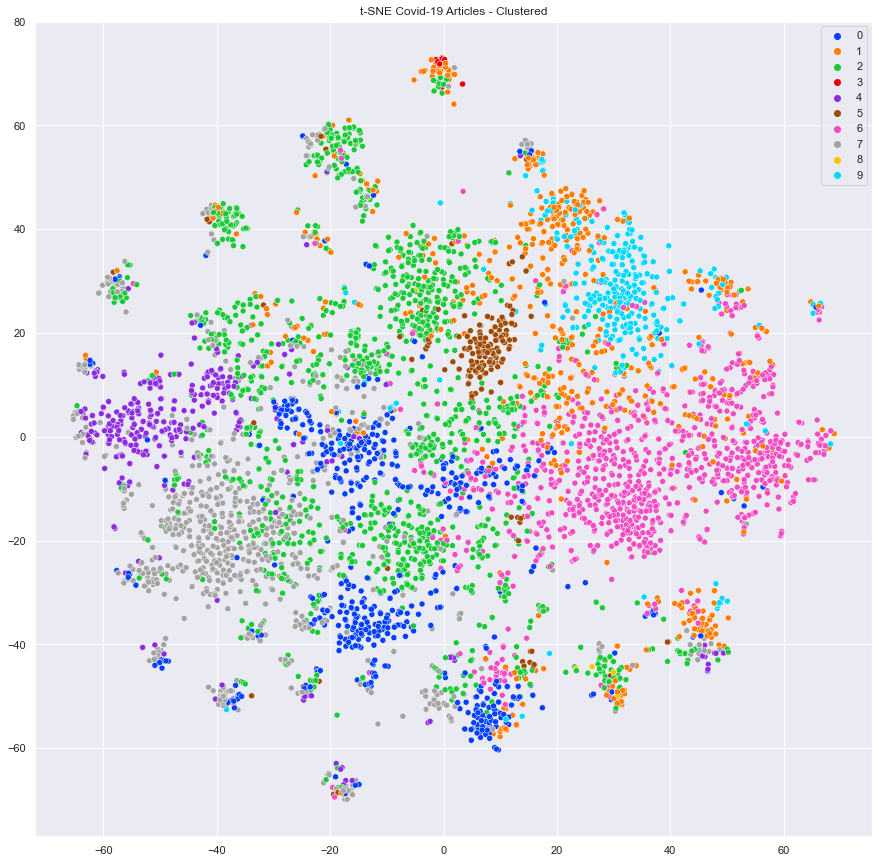

In [79]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", len(set(y_pred)))

# plot
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title("t-SNE Covid-19 Articles - Clustered")
# plt.savefig("plots/t-sne_covid19_label.png")
plt.show()

That looks pretty promising. It can be seen that articles from the same cluster are near each other, forming groups. There are still overlaps. So we will have to see if we can improve this by changing the cluster size, using another clustering algorithm, or different feature size. We can also consider not using 2-grams, or HashVectorizer. We can try 3-grams, 4-grams, or plain text as our instances and vectorize them using either HashVectorizer, Tf-idfVectorizer, or Burrows Wheeler Transform Distance. <br>

Before we try another method for clustering, we want to see how well it will classify using the labels we just created using K-Means.

# Classify

### Helper Function:

In [35]:
# function to print out classification model report
def classification_report(model_name, test, pred):
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='micro')) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='micro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='micro')) * 100), "%")

### Random Forest

In [36]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# random forest classifier instance
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# cross validation on the training set 
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=3, n_jobs=-1)

# print out the mean of the cross validation scores
print("Accuracy: ", '{:,.3f}'.format(float(forest_scores.mean()) * 100), "%")

Accuracy:  67.632 %


In [37]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score

# cross validate predict on the training set
forest_train_pred = cross_val_predict(forest_clf, X_train, y_train, cv=3, n_jobs=-1)

# print precision and recall scores
print("Precision: ", '{:,.3f}'.format(float(precision_score(y_train, forest_train_pred, average='macro')) * 100), "%")
print("   Recall: ", '{:,.3f}'.format(float(recall_score(y_train, forest_train_pred, average='macro')) * 100), "%")

Precision:  76.093 %
   Recall:  63.551 %


In [38]:
# first train the model
forest_clf.fit(X_train, y_train)

# make predictions on the test set
forest_pred = forest_clf.predict(X_test)

In [39]:
# print out the classification report
classification_report("Random Forest Classifier Report (Test Set)", y_test, forest_pred)

Random Forest Classifier Report (Test Set) :

Accuracy Score:  67.964 %
     Precision:  67.964 %
        Recall:  67.964 %
      F1 score:  67.964 %


It looks like it doesn't overfit, which is good news. But results can be better than ~70-80%.

# Vectorize Using Tf-idf with Plain Text
Let's see if we will be able to get better clusters using plain text as instances rather than 2-grams and vectorize it using Tf-idf. Last time we separated the dataset into test and training sets because we wanted to do classification with the labels we got through clustering. This time we will just use the all dataset because the goal is to cluster all literature.

### Vectorize

In [104]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=2**8)
X = vectorizer.fit_transform(df_covid['body_text'].values)

In [105]:
X.shape

(5523, 256)

# MiniBatchKMeans with Plain text and Tf-idf

Again, let's try to get our labels. We will choose 10 clusters again. This time, we will use MiniBatchKMeans as it is faster with more data:

In [99]:
from sklearn.cluster import MiniBatchKMeans

k = 6
kmeans = MiniBatchKMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)

Get the labels:

In [100]:
y = y_pred

# Dimensionality Reduction with t-SNE (Plain text and Tf-idf)

Let's reduce the dimensionality using t-SNE again:

In [63]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5523 samples in 2.634s...
[t-SNE] Computed neighbors for 5523 samples in 62.254s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5523
[t-SNE] Computed conditional probabilities for sample 2000 / 5523
[t-SNE] Computed conditional probabilities for sample 3000 / 5523
[t-SNE] Computed conditional probabilities for sample 4000 / 5523
[t-SNE] Computed conditional probabilities for sample 5000 / 5523
[t-SNE] Computed conditional probabilities for sample 5523 / 5523
[t-SNE] Mean sigma: 0.161256
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.766869
[t-SNE] KL divergence after 1000 iterations: 1.990927


### Plot t-SNE

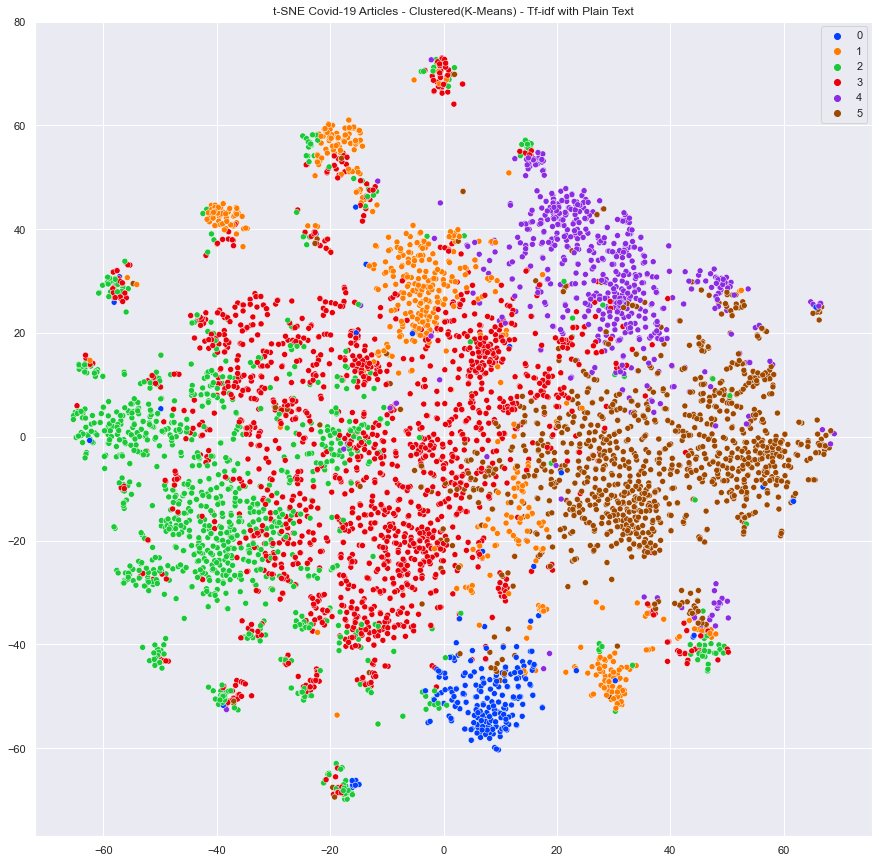

In [106]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", len(set(y)))

# plot
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, legend='full', palette=palette)
plt.title("t-SNE Covid-19 Articles - Clustered(K-Means) - Tf-idf with Plain Text")
# plt.savefig("plots/t-sne_covid19_label_TFID.png")
plt.show()

This time we are able to see the clusters more clearly. There are clusters that further apart from each other. I can also start to see that there is possibly more than 10 clusters we need to identify using k-means.

# Dimensionality Reduction with PCA (Plain text and Tf-idf)

t-SNE doesn't scale well. This is why run-time of this Notebook is about 40 minutes to 1 hour with an average computer. Let's try to see if we dan achive good results with PCA as it scales very well with larger datasets and dimensions:

In [88]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_result = pca.fit_transform(X.toarray())

### Plot PCA

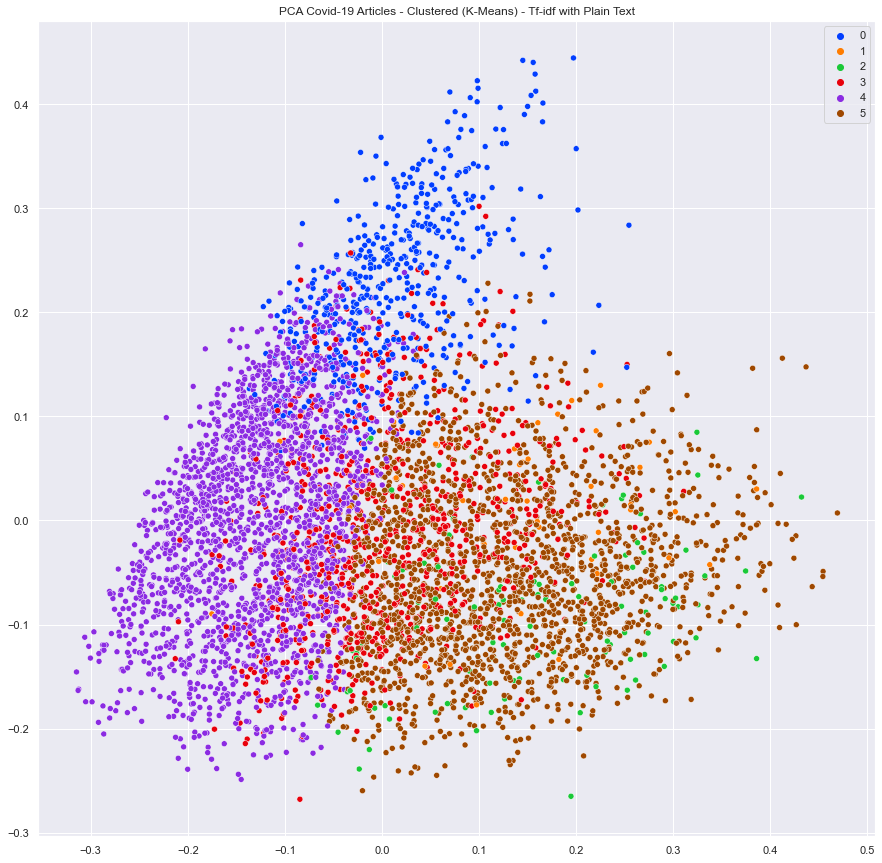

In [89]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", len(set(y)))

# plot
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=y, legend='full', palette=palette)
plt.title("PCA Covid-19 Articles - Clustered (K-Means) - Tf-idf with Plain Text")
# plt.savefig("plots/pca_covid19_label_TFID.png")
plt.show()

Sometimes it may be easier to see the results in a 3 dimensional plot. So let's try to do that:

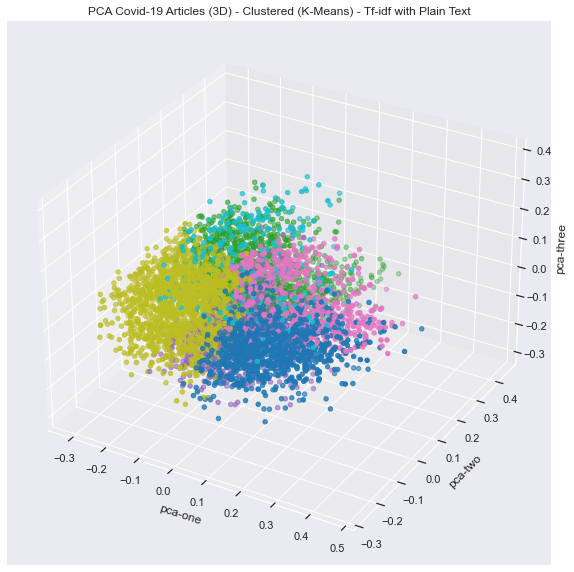

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=pca_result[:,0], 
    ys=pca_result[:,1], 
    zs=pca_result[:,2], 
    c=y, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.title("PCA Covid-19 Articles (3D) - Clustered (K-Means) - Tf-idf with Plain Text")
# plt.savefig("plots/pca_covid19_label_TFID_3d.png")
plt.show()

# More Clusters?
On our previous plot we could see that there is more clusters than only 10. Let's try to label them:

In [107]:
from sklearn.cluster import MiniBatchKMeans

k = 20
kmeans = MiniBatchKMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)
y = y_pred

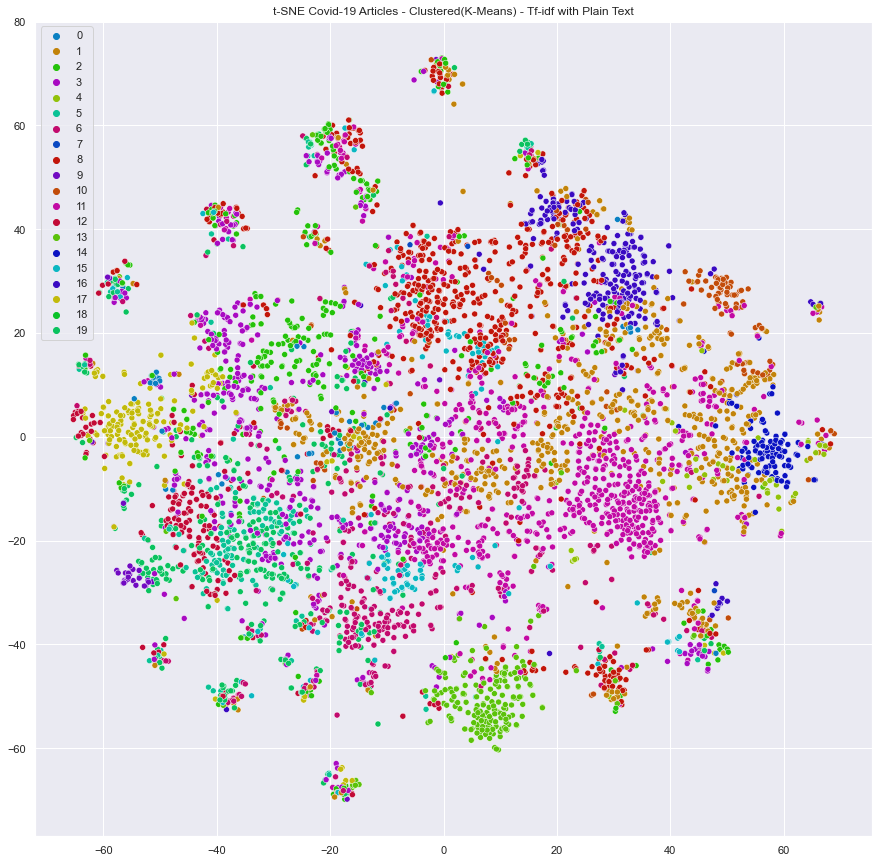

In [108]:
from matplotlib import pyplot as plt
import seaborn as sns
import random 

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# let's shuffle the list so distinct colors stay next to each other
palette = sns.hls_palette(20, l=.4, s=.9)
random.shuffle(palette)

# plot
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, legend='full', palette=palette)
plt.title("t-SNE Covid-19 Articles - Clustered(K-Means) - Tf-idf with Plain Text")
# plt.savefig("plots/t-sne_covid19_20label_TFID.png")
plt.show()

It would be helpful if we have a demo tool that can be used to see what articles are identified as similar using our Clustering and Dimensionality Reduction, right? Let's put together a interactive scatter plot of t-SNE to do that.

# Interactive t-SNE

In [51]:
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, CustomJS
from bokeh.palettes import Category20
from bokeh.transform import linear_cmap
from bokeh.io import output_file, show
from bokeh.transform import transform
from bokeh.io import output_notebook
from bokeh.plotting import figure
from bokeh.layouts import column
from bokeh.models import RadioButtonGroup
from bokeh.models import TextInput
from bokeh.layouts import gridplot
from bokeh.models import Div
from bokeh.models import Paragraph
from bokeh.layouts import column, widgetbox

output_notebook()
y_labels = y_pred

# data sources
source = ColumnDataSource(data=dict(
    x= X_embedded[:,0], 
    y= X_embedded[:,1],
    x_backup = X_embedded[:,0],
    y_backup = X_embedded[:,1],
    desc= y_labels, 
    titles= df_covid['title'],
    authors = df_covid['authors'],
    journal = df_covid['journal'],
    abstract = df_covid['abstract_summary'],
    labels = ["C-" + str(x) for x in y_labels]
    ))

# hover over information
hover = HoverTool(tooltips=[
    ("Title", "@titles{safe}"),
    ("Author(s)", "@authors"),
    ("Journal", "@journal"),
    ("Abstract", "@abstract{safe}"),
],
                 point_policy="follow_mouse")

# map colors
mapper = linear_cmap(field_name='desc', 
                     palette=Category20[20],
                     low=min(y_labels) ,high=max(y_labels))

# prepare the figure
p = figure(plot_width=800, plot_height=800, 
           tools=[hover, 'pan', 'wheel_zoom', 'box_zoom', 'reset'], 
           title="t-SNE Covid-19 Articles, Clustered(K-Means), Tf-idf with Plain Text", 
           toolbar_location="right")

# plot
p.scatter('x', 'y', size=5, 
          source=source,
          fill_color=mapper,
          line_alpha=0.3,
          line_color="black",
          legend = 'labels')
plot.legend.background_fill_alpha = 0.6

# add callback to control 
callback = CustomJS(args=dict(p=p, source=source), code="""
            
            var radio_value = cb_obj.active;
            var data = source.data; 
            
            x = data['x'];
            y = data['y'];
            
            x_backup = data['x_backup'];
            y_backup = data['y_backup'];
            
            labels = data['desc'];
            
            if (radio_value == '20') {
                for (i = 0; i < x.length; i++) {
                    x[i] = x_backup[i];
                    y[i] = y_backup[i];
                }
            }
            else {
                for (i = 0; i < x.length; i++) {
                    if(labels[i] == radio_value) {
                        x[i] = x_backup[i];
                        y[i] = y_backup[i];
                    } else {
                        x[i] = undefined;
                        y[i] = undefined;
                    }
                }
            }


        source.change.emit();
        """)

# callback for searchbar
keyword_callback = CustomJS(args=dict(p=p, source=source), code="""
            
            var text_value = cb_obj.value;
            var data = source.data; 
            
            x = data['x'];
            y = data['y'];
            
            x_backup = data['x_backup'];
            y_backup = data['y_backup'];
            
            abstract = data['abstract'];
            titles = data['titles'];
            authors = data['authors'];
            journal = data['journal'];

            for (i = 0; i < x.length; i++) {
                if(abstract[i].includes(text_value) || 
                   titles[i].includes(text_value) || 
                   authors[i].includes(text_value) || 
                   journal[i].includes(text_value)) {
                    x[i] = x_backup[i];
                    y[i] = y_backup[i];
                } else {
                    x[i] = undefined;
                    y[i] = undefined;
                }
            }
            


        source.change.emit();
        """)

# option
option = RadioButtonGroup(labels=["C-0", "C-1", "C-2",
                                  "C-3", "C-4", "C-5",
                                  "C-6", "C-7", "C-8",
                                  "C-9", "C-10", "C-11",
                                  "C-12", "C-13", "C-14",
                                  "C-15", "C-16", "C-17",
                                  "C-18", "C-19", "All"], 
                          active=20, callback=callback)

# search box
keyword = TextInput(title="Search:", callback=keyword_callback)

#header
header = Div(text="""<h1>COVID-19 Literature Cluster</h1>""")

# show
show(column(header, widgetbox(option, keyword),p))

Loading BokehJS ...

AttributeError: unexpected attribute 'callback' to RadioButtonGroup, similar attributes are js_event_callbacks

#### Please see the tools on right top.
#### If the text doesn't fit in the screen on the above plot when hover, please try the 'Box Zoom' tool to zoom to the area where the target plot is. This will help the hover message to fit the screen. 
#### Use the 'Reset' button to revert the zoom.

This notebook is adaption from the following kaggle notebook https://www.kaggle.com/maksimeren/covid-19-literature-clustering
### You can find the full version of the interactive plot here on GitHub: 
#### https://maksimekin.github.io/COVID19-Literature-Clustering/plots/t-sne_covid-19_interactive.html
